This notebook sanitizes flight data from the US from 2011 - 2012.
This data is then used to create a model to predict if a given flight will be delayed or not.

In [27]:
# Load dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() 

# Loading and initial view of the data

In [28]:
df = pd.read_csv("flights_2010_000000000000.gzip", compression="gzip");
df.append(pd.read_csv("flights_2010_000000000001.gzip", compression="gzip"));
df.append(pd.read_csv("flights_2010_000000000002.gzip", compression="gzip"));
df.append(pd.read_csv("flights_2010_000000000003.gzip", compression="gzip"));
df.append(pd.read_csv("flights_2010_000000000004.gzip", compression="gzip"));
df.append(pd.read_csv("flights_2010_000000000005.gzip", compression="gzip"));
df.head()

,date,airline,airline_code,departure_airport,departure_state,departure_lat,departure_lon,arrival_airport,arrival_state,arrival_lat,arrival_lon,departure_schedule,departure_actual,departure_delay,arrival_schedule,arrival_actual,arrival_delay
0,2012-11-25,US,20355,CLT,NC,35.21,-80.94,PHL,PA,39.87,-75.24,1755,1805,10,1931,1948,17
1,2012-11-29,US,20355,CLT,NC,35.21,-80.94,PHL,PA,39.87,-75.24,1755,1752,-3,1931,1929,-2
2,2012-11-29,US,20355,CLT,NC,35.21,-80.94,PHL,PA,39.87,-75.24,1445,1442,-3,1623,1615,-8
3,2012-11-29,US,20355,CLT,NC,35.21,-80.94,PHL,PA,39.87,-75.24,2005,2007,2,2140,2139,-1
4,2012-11-29,US,20355,CLT,NC,35.21,-80.94,PHL,PA,39.87,-75.24,1630,1624,-6,1808,1805,-3


## Description of the data
We could quickly see that there were no Null values.

As for the delays there were some anomalies such as delays of over 1000 minutes. These will be checked and eventually cleaned.

When describing the data we can see at a glance when the most flights were, which airline flew the most, etc.

In [29]:
df.isnull().sum()

date                  0
airline               0
airline_code          0
departure_airport     0
departure_state       0
departure_lat         0
departure_lon         0
arrival_airport       0
arrival_state         0
arrival_lat           0
arrival_lon           0
departure_schedule    0
departure_actual      0
departure_delay       0
arrival_schedule      0
arrival_actual        0
arrival_delay         0
dtype: int64

In [30]:
df[["departure_schedule", "departure_delay", "arrival_schedule", "arrival_delay"]].describe()

,departure_schedule,departure_delay,arrival_schedule,arrival_delay
count,1.898651e+06,1.898651e+06,1.898651e+06,1.898651e+06
mean,1.328128e+03,8.119147e+00,1.498313e+03,3.942449e+00
std,4.695833e+02,3.300028e+01,4.886834e+02,3.553357e+01
min,1.000000e+00,-2.260000e+02,1.000000e+00,-4.110000e+02
25%,9.250000e+02,-5.000000e+00,1.115000e+03,-1.200000e+01
50%,1.320000e+03,-2.000000e+00,1.520000e+03,-4.000000e+00
75%,1.724000e+03,6.000000e+00,1.910000e+03,7.000000e+00
max,2.359000e+03,1.606000e+03,2.400000e+03,1.592000e+03


In [31]:
df.describe(include=['O'])

,date,airline,departure_airport,departure_state,arrival_airport,arrival_state
count,1898651,1898651,1898651,1898651,1898651,1898651
unique,700,17,307,52,307,52
top,2011-06-27,WN,ATL,CA,ATL,CA
freq,3098,360373,121942,232376,122436,231476


## Definition of delay
We determined that a flight was only delayed when the actual delay was greater than 15 minutes (FAA declaration). This information (True/False) was added to the dataframe.

With this information we could calculate the percentage of delayed flights overall.

We could also find out which airlines and airports had the most delays.


In [32]:
# a flight is delayed when delay is bigger than 15 mins
df["is_delayed"] = (df["arrival_delay"]) > 15

delayed = df[df['is_delayed'] == 1]
not_delayed = df[df['is_delayed'] == 0]

print ("Delayed: %i (%.1f%%)"%(len(delayed), float(len(delayed))/len(df)*100.0))
print ("Not delayed: %i (%.1f%%)"%(len(not_delayed), float(len(not_delayed))/len(df)*100.0))
print ("Total: %i"%len(df))

Delayed: 324145 (17.1%)
Not delayed: 1574506 (82.9%)
Total: 1898651


In [34]:
# worst airlines
airlines_delay = df[["airline", "is_delayed"]].groupby(["airline"]).mean()
print(airlines_delay.sort_values(by="is_delayed", ascending=False).head())

         is_delayed
airline            
B6         0.218805
XE         0.215456
EV         0.210453
CO         0.204899
F9         0.197519


In [36]:
# find worst departure airports
airports_delay = df[['departure_airport', 'is_delayed']].groupby(['departure_airport']).mean()
print(airports_delay.sort_values(by="is_delayed", ascending=False).head())

                   is_delayed
departure_airport            
TTN                  1.000000
SHD                  0.500000
ACV                  0.347784
OTH                  0.345048
PLN                  0.333333


# Cleaning the data
## Removing data
Airports and airlines which had a substantialy low amount of flights do not fit in our model since this would throw off our prediction. This amount was arbitrarily set to 1000 flights.


In the EU if a flight is delayed for over three hours reimbursment is entitles. The FAA imposes a fine if the flight has not taken off in three hours. This is why the flights where this happened were deleted. Following this, to keep our model predictable, flights that were abnomarly early were also deleted.

In [39]:
# delete airports with less than 1000 incoming / outgoing flights
all_airports = df.departure_airport.value_counts()
good_airports = all_airports[all_airports >= 1000]
df = df.loc[df["departure_airport"].isin(good_airports.keys())]
df = df.loc[df["arrival_airport"].isin(good_airports.keys())]

# Confirm no bad airports were left in the dataframe
df.departure_airport.value_counts().tail()

RDM    1047
ATW    1046
EVV    1026
PSC    1015
PIA    1013
Name: departure_airport, dtype: int64

In [40]:
# delete airlines with fewer than 1000 flights ## not necessary
df.airline.value_counts().tail()

CO    39873
AS    38029
F9    25906
HA    22584
VX     8272
Name: airline, dtype: int64

In [44]:
# remove flights with excessive delay
df = df.loc[(abs(df.arrival_delay) <= 180)]
df = df.loc[(abs(df.departure_delay) <= 180)]
df[["departure_delay", "arrival_delay"]].describe()

,departure_delay,arrival_delay
count,1.781900e+06,1.781900e+06
mean,6.480139e+00,2.166375e+00
std,2.396647e+01,2.703916e+01
min,-5.000000e+01,-9.000000e+01
25%,-5.000000e+00,-1.200000e+01
50%,-1.000000e+00,-4.000000e+00
75%,6.000000e+00,7.000000e+00
max,1.800000e+02,1.800000e+02


## Adding data
The departure and arrival times were in HHMM format, but this is not useful to train our model, so we added columns to see in what hour these times were.

As for the airport code, we had to convert strings to integers to be able to use this column in our training model. This was easily done with a dictionary.

In [45]:
# get hours of departure & arrival instead of hour and minutes
df["departure_schedule_hour"] = df.departure_schedule // 100
df["arrival_schedule_hour"] = df.arrival_schedule // 100

In [47]:
# add extra data
# string to integer
airport_mapping = {k: v for v, k in enumerate(sorted(set(df.departure_airport.unique())))}

# keep pandas from complaining
pd.options.mode.chained_assignment = None

for row in [df]:
    row["departure_airport_int"] = row["departure_airport"].map(airport_mapping).astype(int)
    row["arrival_airport_int"] = row["arrival_airport"].map(airport_mapping).astype(int)
    
df[["airline", "departure_airport", "departure_airport_int"]].sample(5)

,airline,departure_airport,departure_airport_int
714045,FL,BWI,23
225794,UA,ORD,112
102719,DL,JFK,78
1231064,AA,BUR,22
1062776,AA,LAX,81


## Slimming data
Only data data that is useful to have in our model is kept from now on.

In [49]:
df_slim = df[["is_delayed", "airline_code", "departure_schedule_hour", "arrival_schedule_hour", "departure_airport_int", "arrival_airport_int"]]
df_slim.sample(5)

,is_delayed,airline_code,departure_schedule_hour,arrival_schedule_hour,departure_airport_int,arrival_airport_int
1214318,False,19393,6,8,91,40
805032,False,19977,22,23,140,133
1174283,False,20437,20,21,8,91
935901,False,19393,8,9,154,37
704284,False,19930,8,16,139,39


# Training our data
To apply machine learning to our data, we have to split it into a training and a testing part. The testing part is to determine if model is accurate or not. The splitting mask was set to 80%.

By visualising the correlation between columns we could see certain obvious results. But we could also see that arrival_schedule_hour and is_delayed were relatively correlated.

In [50]:
# splitting data
mask = np.random.rand(len(df)) < 0.8
train = df_slim[mask]
test = df_slim[~mask]

#define training and testing set
x_train = train.drop("is_delayed", axis=1)
y_train = train["is_delayed"]
x_test = test.drop("is_delayed", axis=1).copy()

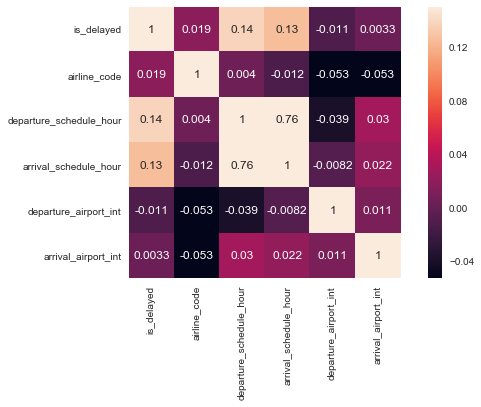

In [51]:
plt.figure(figsize=(10,5))
sns.heatmap(df_slim.corr(), vmax=0.15, square=True, annot=True)

In [55]:
train.shape

(1425603, 6)

In [54]:
test.shape

(356297, 6)

## Random forest
By logical thinking and trial and error we found that the classifier 'Random Forest' was the most accurate.

In [24]:
# Importing Classifier Module
from sklearn.ensemble import RandomForestClassifier

In [254]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc = round(clf.score(x_train, y_train) * 100, 2)
acc

83.86

# NetworkX graphical view
## Preparation
With NetworkX we can display the data as flight path and see some interesting results.

In [276]:
# load depedencies
import networkx as nx
import cartopy.crs as ccrs

By defining our edges (i.e. flight paths) we can use the networkx library to recognise the nodes (i.e. airports). (see: Graph theory)

In [265]:
edges = df[["departure_airport", "arrival_airport"]].as_matrix()
graph = nx.from_edgelist(edges)
print("There are {} nodes (airports) and {} edges (flight paths).".format(len(g.nodes()), len(g.edges())))

There are 159 nodes (airports) and 2014 edges (flight paths).


In order for NetworkX to know where to plot the nodes, it needs the longituted and latitute from the airports. This is were the mapping is created.

In [272]:
airports = df[['departure_airport', 'departure_lon', 'departure_lat']].drop_duplicates().set_index('departure_airport')

airport_pos_mapping = {airport: (float(v['departure_lon']), float(v['departure_lat']))
       for airport, v in
       airports.to_dict('index').items()}

The degree of a node shows how many connected nodes there are, so we want the node to display as 5 times the amount of connections it had.

Only if a node has more than 30 connection we will show the label of the airport on the map.

In [314]:
deg = nx.degree(graph)
sizes = [5*deg[airport] for airport in graph.nodes]
labels = {airport: airport if deg[airport] > 30 else '' for airport in graph.nodes}

## The map
Cartopy gives us a full world map, so with ax.set_extent() we zoom in for the US. After that we tell networkx to use our labels, node sizes, airport mapping and the created matplotlib axes.

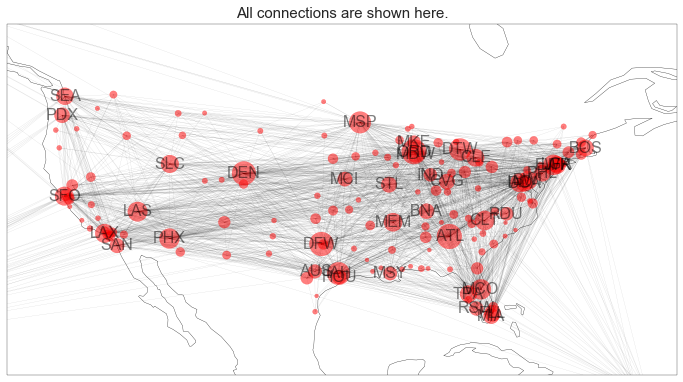

In [317]:
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw=dict(projection=crs))
plt.title("All connections are shown here.", fontsize=15)
ax.coastlines()
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(graph, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=airport_pos_mapping,
                 cmap=plt.cm.magma,
                 label=label)

# Exporting
We wanted to use our model outside of this notebook so we exported all the needed material to use the model in other projects.

We need:
* The model (export with sklearn)
* The mapping (export with numpy)

In [282]:
# save model
from sklearn.externals import joblib
joblib.dump(clf, 'modeldump.pkl') 

# save mapping
np.save("airport_mapping.npy", airport_mapping)

# Conclusion

We analysed flight delays and were able to find some interesting facts:

* The biggest airport is Atlanta (ATL)
* The biggest airline is Southwest Airline (WN)
* JetBlue airline (B6) has the most overall delays
* Medford airport (MFR) has the most overall delays for departing planes


In the end we build a machine learning model which is able to predict flight delays with an accuracy of 84%.

We are aware that given the amount of data, this accuracy is not real-world applicable, as flight delays are mostly correlated to the weather, aircraft type, age of aircraft, etc.